In [41]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.stats import norm
from arch import arch_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Fama-French 3 factor model

In [48]:
dataset = pd.read_csv('esg index.csv')

X = dataset.iloc[:, -2].values.reshape(-1, 1)
Y = dataset.iloc[:, 1:4].values

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, Y)

alpha = lr.intercept_
coef = lr.coef_
print(alpha)
print(coef)

[ 0.00639223 -0.00523968 -0.02484864]
[[ 0.97123532]
 [ 0.20279706]
 [-0.27583035]]


In [50]:
mkt = yf.download('SPY', start='2012-11-01',end='2022-11-01')['Adj Close']
mkt_ret = np.log(mkt / mkt.shift(1)) * 100
mkt_ret.dropna(inplace=True)
mkt_vol = mkt_ret.std()


price = yf.download('SUSA', start='2012-11-01',end='2022-11-01')['Adj Close']
ret = np.log(price / price.shift(1)) * 100
ret.dropna(inplace=True)
esg_vol = ret.std()
print([mkt_vol, esg_vol])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[1.0882483789042043, 1.090805005652328]


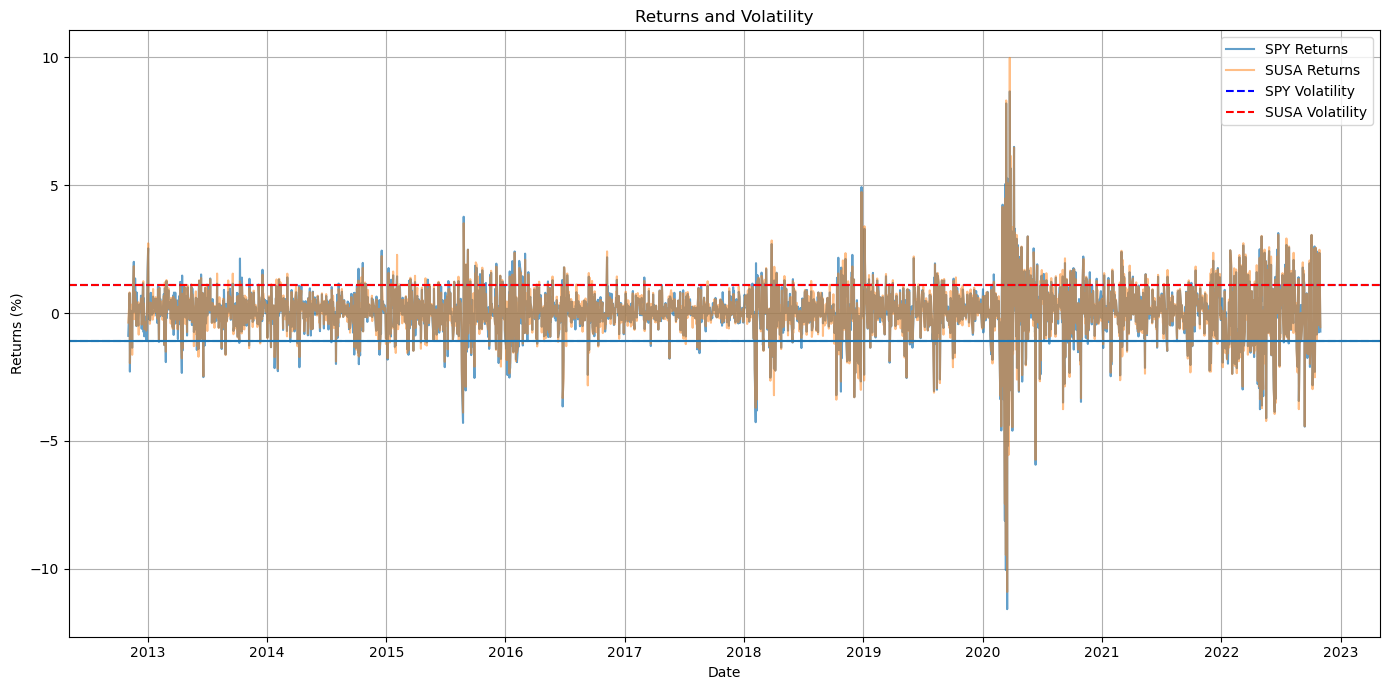

In [51]:
plt.figure(figsize=(14, 7))

# Plotting returns
plt.plot(mkt_ret, label="SPY Returns", alpha=0.7)
plt.plot(ret, label="SUSA Returns", alpha=0.5)

# Highlighting the standard deviations
plt.axhline(y=mkt_vol, color='b', linestyle='--', label="SPY Volatility")
plt.axhline(y=-mkt_vol, linestyle='--')
plt.axhline(y=esg_vol, color='r', linestyle='--', label="SUSA Volatility")
plt.axhline(y=-esg_vol, linestyle='-')


# Title, labels, and legend
plt.title("Returns and Volatility")
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


### value at risk parametric method

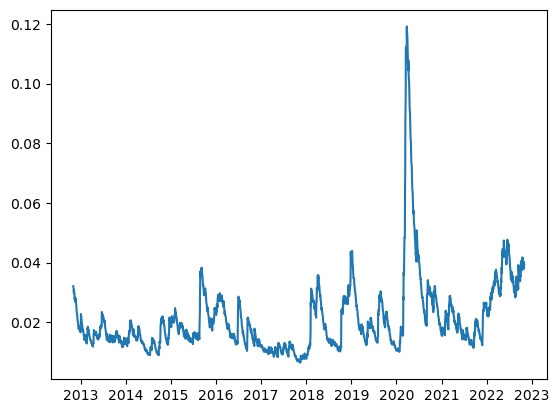

In [52]:
T = len(ret)
ret = ret/100
rm_sigma2 = np.zeros(T)
rm_sigma2[0] = 0.014 ** 2
for i in range(1, T):
    rm_sigma2[i] = 0.94 * rm_sigma2[i-1] + 0.06 * ret[i-1]**2

mean_ret = ret.mean()

rm_sigma = np.sqrt(rm_sigma2)
rm_var = norm.ppf(0.01, loc=mean_ret, scale=rm_sigma)
plt.plot(ret.index, -rm_var, label='1% VaR')
plt.show()

### Historical simulation

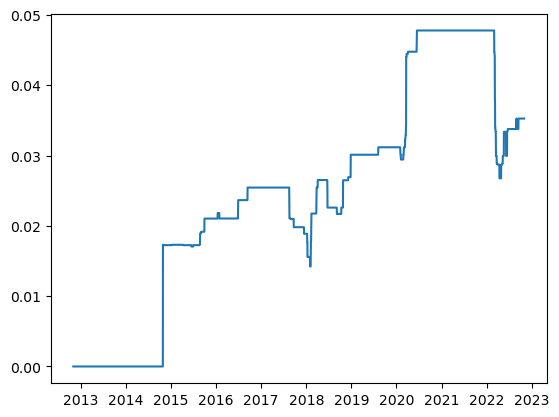

In [53]:
hs_var = np.zeros(T)
for i in range(500, T):
    retwindow = ret[(i-500):(i-1)]
    hs_var[i] = np.percentile(retwindow, 1)
plt.plot(ret.index, -hs_var)
plt.show()

### Garch(1, 1) model

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8426.495996849575
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


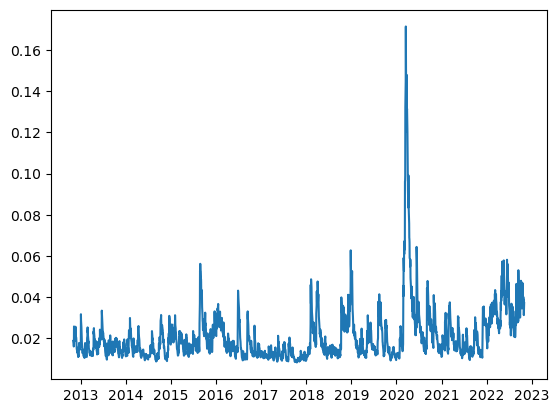

In [54]:
garch_model = arch_model(ret, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(update_freq=5)

# Obtain conditional volatilities
conditional_volatility = garch_fit.conditional_volatility

# Calculate 1% VaR
mean_ret = ret.mean()
z_score = norm.ppf(0.01)  # z-score for 1% level
garch_var = mean_ret + z_score * conditional_volatility
plt.plot(ret.index, -garch_var)

### Filter histroical simulation

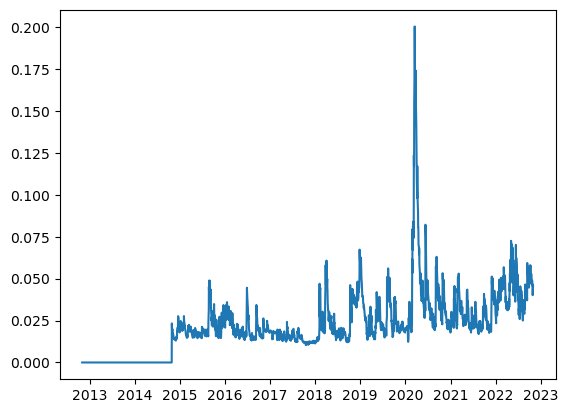

In [55]:
var_fhs = np.zeros(T)
for i in range(500, T):
    ret_window = ret.iloc[i-500 :i]
    
    garch = arch_model(ret_window, vol='Garch', p=1, q=1).fit(disp='off')
    omega, alpha, beta = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    sigma = np.sqrt(omega + alpha * ret_window.iloc[-1] ** 2 + beta * garch.conditional_volatility[-1] ** 2)

    # Filtered Historical Simulation
    standardized_returns = ret_window / garch.conditional_volatility
    var_fhs[i] = sigma * np.percentile(standardized_returns, 1)

plt.plot(ret.index, -var_fhs)

### make a 1-day prediction by FHS model

In [56]:
ret_window = ret.iloc[-500:]
# Get the window of the most recent 500 days' returns
ret_window = ret.iloc[-500:]

garch = arch_model(ret_window, vol='Garch', p=1, q=1).fit(disp='off')
omega, alpha, beta = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
next_day_sigma = np.sqrt(omega + alpha*ret_window.iloc[-1]**2 + beta*garch.conditional_volatility[-1]**2)

standardized_return = ret_window / garch.conditional_volatility
next_day_var_fhs = next_day_sigma * np.percentile(standardized_return, 1)
print(-next_day_var_fhs)

0.04287221506215046
